# Customer Segmentation

## Importing Libraries and Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from datetime import datetime, timedelta

In [3]:
online_retail_df = pd.read_parquet('../data/cleaned/online_retail_cleaned.parquet')
uk_rfm = pd.read_parquet('../data/cleaned/uk_rfm_cleaned.parquet')

In [4]:
online_retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,Day,Week,DayOfWeek,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,1,49,1,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,49,1,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,49,1,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,1,49,1,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,1,49,1,30.0


In [5]:
uk_rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,-1.0,0,225651,3021334.77
1,12346.0,325,34,77556.46
2,12608.0,404,16,415.79
3,12745.0,486,22,723.85
4,12746.0,540,17,254.55


## Customer Segmentation with RFM Analysis

In [6]:
uk_rfm.describe()

,Customer ID,Recency,Frequency,Monetary
count,5351.000000,5351.000000,5351.000000,5.351000e+03
mean,15554.455055,201.963184,173.059054,3.253704e+03
std,1595.256128,209.957769,3098.850238,4.289426e+04
min,-1.000000,0.000000,1.000000,2.950000e+00
25%,14190.500000,25.000000,20.000000,3.302850e+02
50%,15565.000000,97.000000,52.000000,8.294700e+02
75%,16922.500000,381.000000,137.500000,2.156560e+03
max,18287.000000,738.000000,225651.000000,3.021335e+06


In [7]:
Q1 = uk_rfm['Monetary'].quantile(0.01)  # 1st percentile
Q3 = uk_rfm['Monetary'].quantile(0.99)  # 99th percentile
IQR = Q3 - Q1
uk_rfm_filtered = uk_rfm[
    (uk_rfm['Monetary'] >= Q1 - 1.5 * IQR) & 
    (uk_rfm['Monetary'] <= Q3 + 1.5 * IQR)
]

In [8]:
if -1 in uk_rfm['Customer ID'].values:
    uk_rfm_filtered = uk_rfm_filtered[uk_rfm_filtered['Customer ID'] != -1]

In [9]:
print(f"Original RFM data size: {uk_rfm.shape[0]}")
print(f"Filtered RFM data size (after removing outliers): {uk_rfm_filtered.shape[0]}")

Original RFM data size: 5351
Filtered RFM data size (after removing outliers): 5332


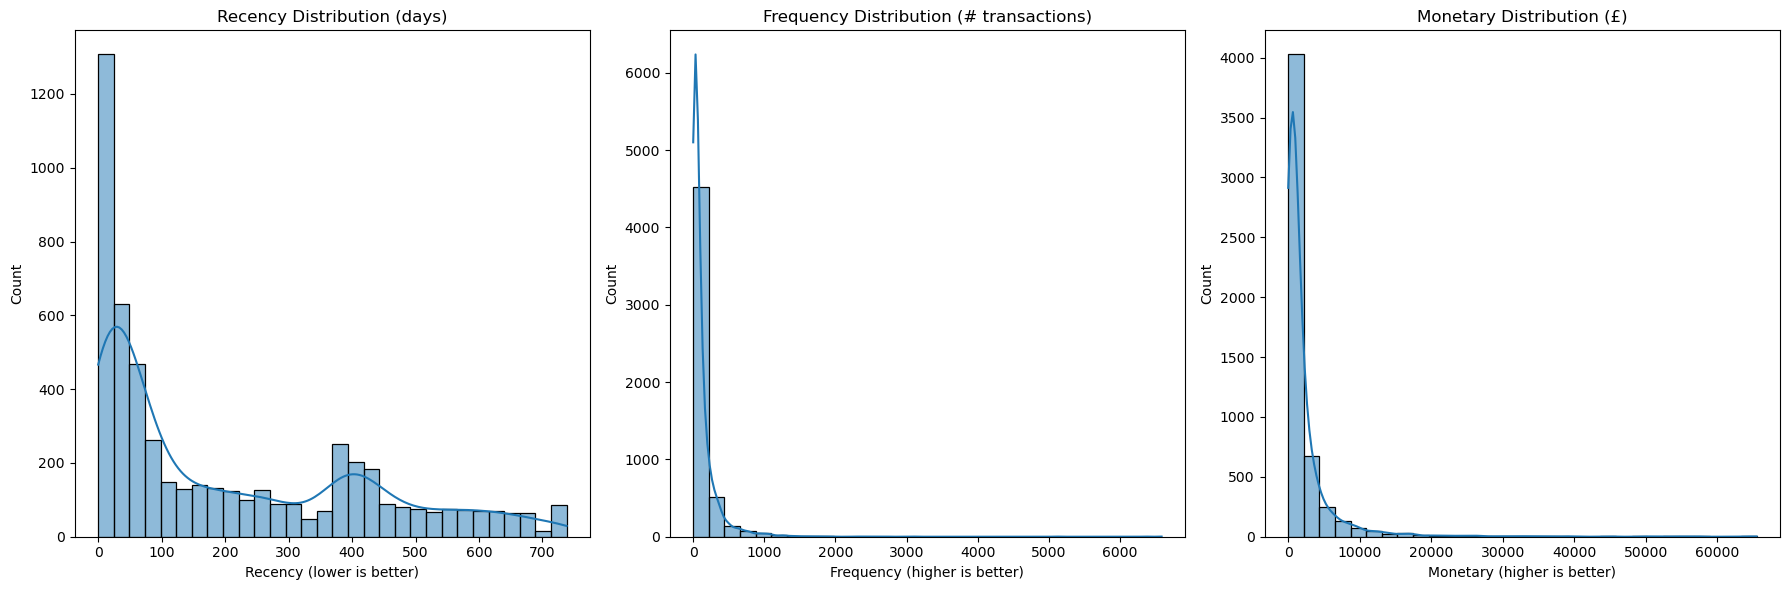

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Recency distribution
sns.histplot(uk_rfm_filtered['Recency'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Recency Distribution (days)')
ax[0].set_xlabel('Recency (lower is better)')

# Frequency distribution
sns.histplot(uk_rfm_filtered['Frequency'], bins=30, kde=True, ax=ax[1])
ax[1].set_title('Frequency Distribution (# transactions)')
ax[1].set_xlabel('Frequency (higher is better)')

# Monetary distribution
sns.histplot(uk_rfm_filtered['Monetary'], bins=30, kde=True, ax=ax[2])
ax[2].set_title('Monetary Distribution (£)')
ax[2].set_xlabel('Monetary (higher is better)')

plt.tight_layout()
plt.show()

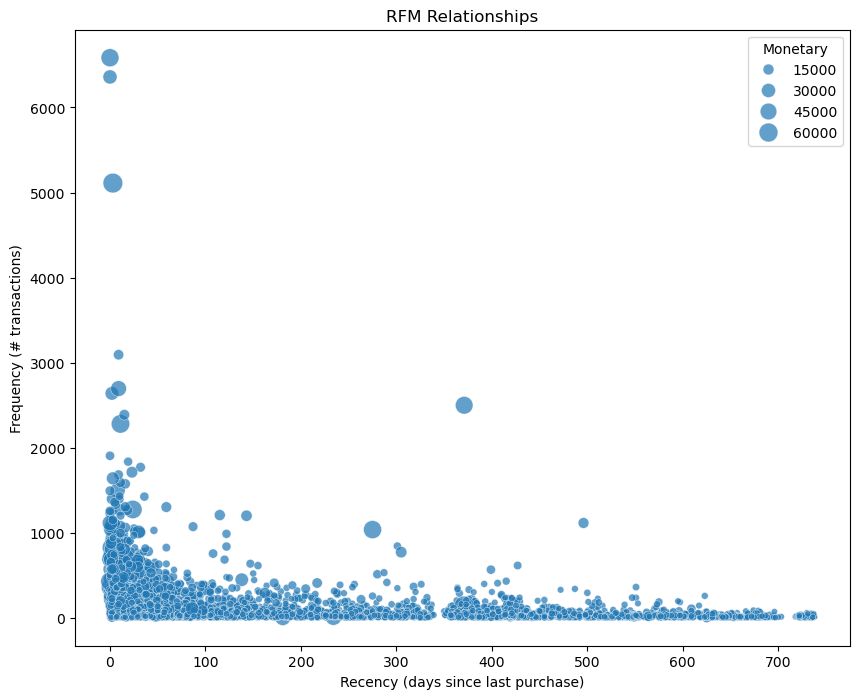

<Figure size 1200x1000 with 0 Axes>

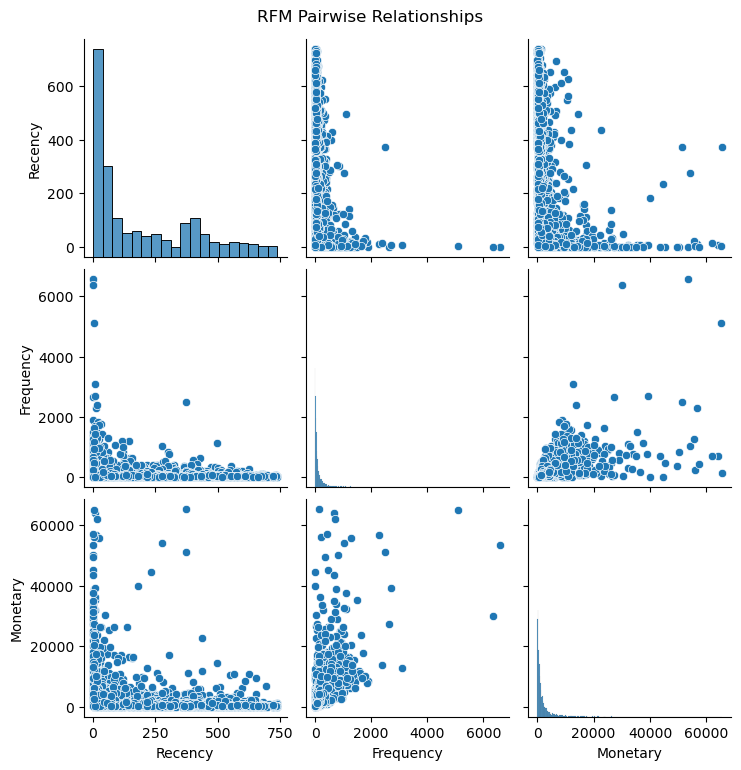

In [11]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=uk_rfm_filtered, x='Recency', y='Frequency', size='Monetary', sizes=(20, 200), alpha=0.7)
plt.title('RFM Relationships')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (# transactions)')
plt.show()

# Also create a pairplot to see all relationships
plt.figure(figsize=(12, 10))
sns.pairplot(uk_rfm_filtered[['Recency', 'Frequency', 'Monetary']])
plt.suptitle('RFM Pairwise Relationships', y=1.02)
plt.show()

### Feature Preprocessing

In [12]:
uk_rfm_processed = uk_rfm_filtered.copy()
features = uk_rfm_processed[['Recency', 'Frequency', 'Monetary']].values

scaler = RobustScaler()
features_scaled = scaler.fit_transform(features)

rfm_features_scaled = pd.DataFrame(
    features_scaled, 
    columns=['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled'],
    index=uk_rfm_processed.index
)

rfm_features_scaled['Recency_Scaled'] = rfm_features_scaled['Recency_Scaled']
uk_rfm_processed = pd.concat([uk_rfm_processed, rfm_features_scaled], axis=1)

### Dimensionality Reduction

In [13]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_features_scaled)
principal_df = pd.DataFrame(
    data=principal_components, 
    columns=['PC1', 'PC2'],
    index=uk_rfm_processed.index
)
uk_rfm_processed = pd.concat([uk_rfm_processed, principal_df], axis=1)

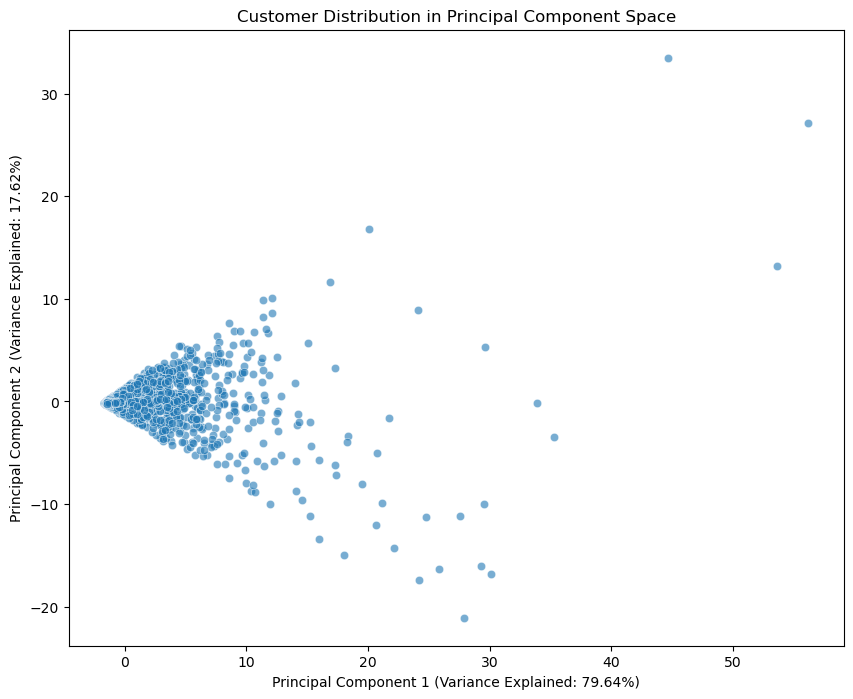

Total variance explained by 2 principal components: 97.26%


In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=uk_rfm_processed, x='PC1', y='PC2', alpha=0.6)
plt.title('Customer Distribution in Principal Component Space')
plt.xlabel(f'Principal Component 1 (Variance Explained: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Principal Component 2 (Variance Explained: {pca.explained_variance_ratio_[1]:.2%})')
plt.show()

print(f"Total variance explained by 2 principal components: {sum(pca.explained_variance_ratio_):.2%}")

In [15]:
MAX_K = 10
MAX_ITER = 1000

silhouette_scores = []
inertia_values = []
k_values = range(2, MAX_K + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_features_scaled)
    silhouette_avg = silhouette_score(rfm_features_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    inertia_values.append(kmeans.inertia_)


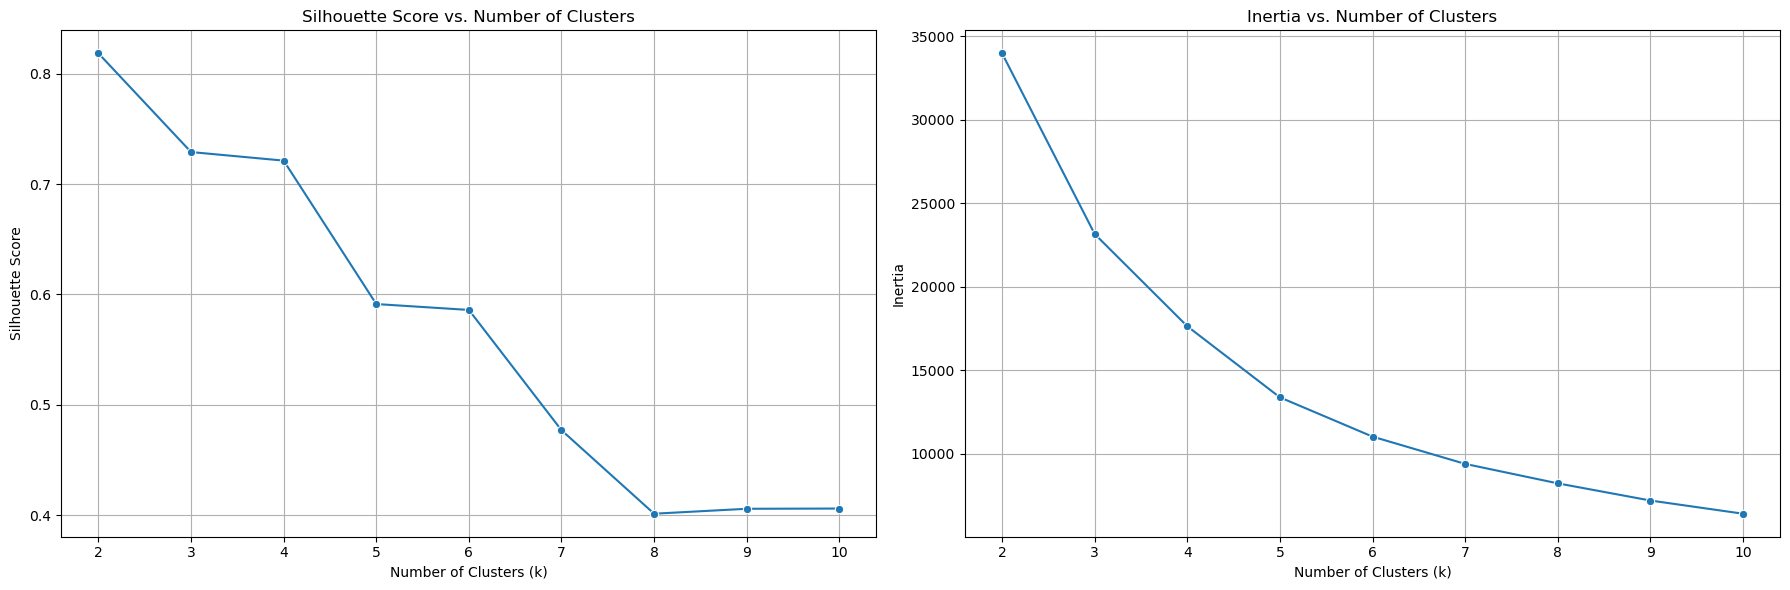

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
# Silhouette score plot
sns.lineplot(x=k_values, y=silhouette_scores, marker='o', ax=ax[0])
ax[0].set_title('Silhouette Score vs. Number of Clusters')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Silhouette Score')
ax[0].grid(True)

# Inertia plot
sns.lineplot(x=k_values, y=inertia_values, marker='o', ax=ax[1])
ax[1].set_title('Inertia vs. Number of Clusters')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Inertia')
ax[1].grid(True)
plt.tight_layout()

In [17]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(rfm_features_scaled)

uk_rfm_processed['KMeans_Cluster'] = kmeans_labels

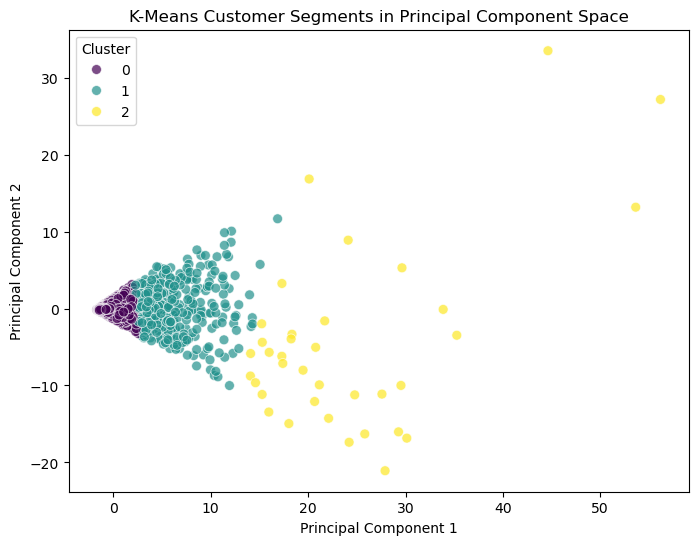

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=uk_rfm_processed, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis', s=50, alpha=0.7)
plt.title('K-Means Customer Segments in Principal Component Space')
plt.xlabel(f'Principal Component 1')
plt.ylabel(f'Principal Component 2')
plt.legend(title='Cluster')

### Interpreting Results

- **Cluster 0 (majority of points)**: These are likely your "regular" customers with moderate recency, frequency, and monetary values.
- **Cluster 1 (points to the right)**: These appear to be your high-value customers with higher transaction frequency and spending.
- **Cluster 2 (scattered points)**: Possibly customers with unusual patterns - perhaps those who made few purchases but spent a lot, or purchased frequently but spent little.

In [19]:
cluster_profiles = uk_rfm_processed.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_profiles)

                   Recency    Frequency      Monetary
KMeans_Cluster                                       
0               219.299627    75.910070   1170.771762
1                43.285106   536.689362   9707.170028
2                44.250000  1402.444444  41967.218972


In [20]:
segment_names = {
    0: "Regular Customers",
    1: "VIP/High-Value Customers",
    2: "Infrequent Big Spenders"
}
uk_rfm_processed['Segment'] = uk_rfm_processed['KMeans_Cluster'].map(segment_names)

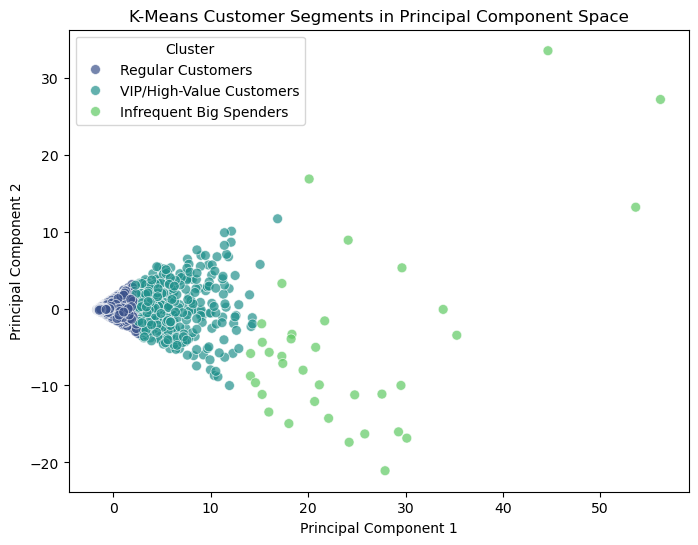

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=uk_rfm_processed, x='PC1', y='PC2', hue='Segment', palette='viridis', s=50, alpha=0.7)
plt.title('K-Means Customer Segments in Principal Component Space')
plt.xlabel(f'Principal Component 1')
plt.ylabel(f'Principal Component 2')
plt.legend(title='Cluster')

Text(0.5, 1.0, 'Customer Segments by Recency and Monetary Value')

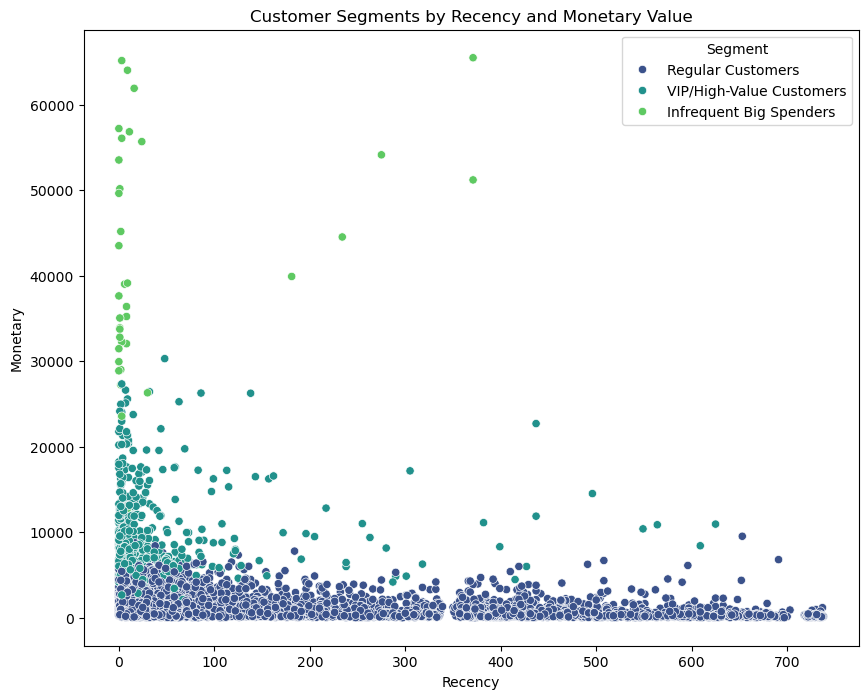

In [22]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=uk_rfm_processed, x='Recency', y='Monetary', hue='Segment', palette='viridis')
plt.title('Customer Segments by Recency and Monetary Value')